# Part 3: Hidden Object Detection Challenge

## Objective
- Simulate cluttered scenes (metal hidden behind objects).
- Apply noise filtering and background subtraction.
- Test model performance on cluttered samples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fft2, fftshift

# Import our utility functions
from radar_utils import generate_radar_cube, process_radar_cube, get_random_scenario, N_chirps, N_samples

## 1. Simulate Hidden Object Scenario

We simulate a scenario where a metal object has a weaker signal (lower RCS) and is surrounded by stronger clutter.

Generating Hidden Metal Scenario...


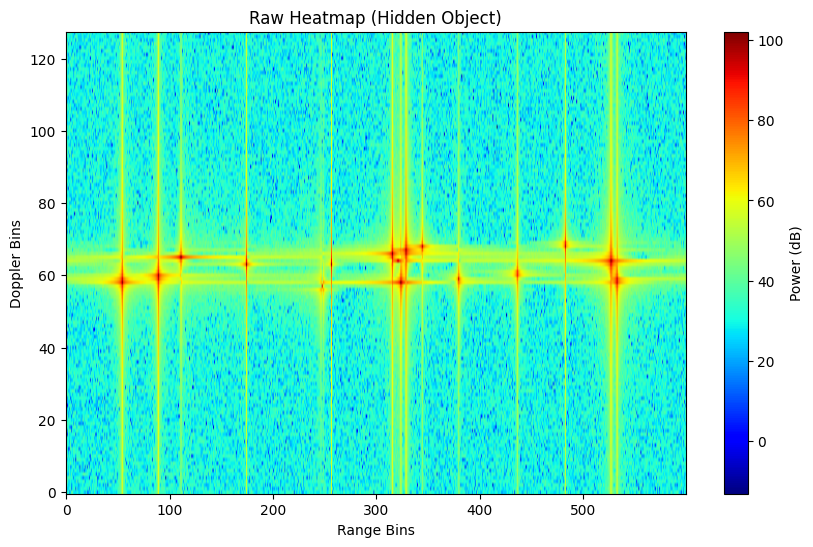

In [2]:
print("Generating Hidden Metal Scenario...")
targets = get_random_scenario('hidden_metal')
cube_raw = generate_radar_cube(N_chirps, N_samples, targets)
rd_map_raw = process_radar_cube(cube_raw)

def plot_heatmap(range_doppler, title="Range-Doppler Heatmap"):
    mag = 20 * np.log10(np.abs(range_doppler) + 1e-9)
    plt.figure(figsize=(10, 6))
    plt.imshow(mag, aspect='auto', cmap='jet', origin='lower')
    plt.title(title)
    plt.xlabel('Range Bins')
    plt.ylabel('Doppler Bins')
    plt.colorbar(label='Power (dB)')
    plt.show()

plot_heatmap(rd_map_raw, title="Raw Heatmap (Hidden Object)")

## 2. Background Subtraction / Filtering

To detect the hidden object, we can try to subtract a static background or filter out noise.
Since our simulation generates new random clutter each time, "static background subtraction" is tricky without a reference "empty" frame of the *exact same* clutter configuration.

However, in a real scenario, clutter (walls, furniture) is static (zero velocity). The target might be static or moving.
If the target is static and hidden by static clutter, it's very hard to detect with just one frame.

Let's assume we can capture a "background" frame (clutter only) and then a "target" frame (clutter + target).

**Strategy:**
1. Generate Clutter Only (Background).
2. Generate Clutter + Target.
3. Subtract Background from Target frame.

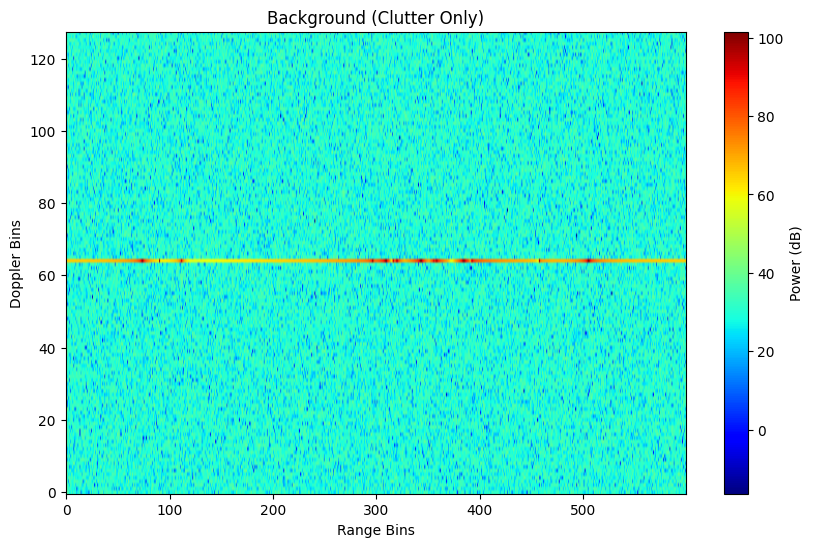

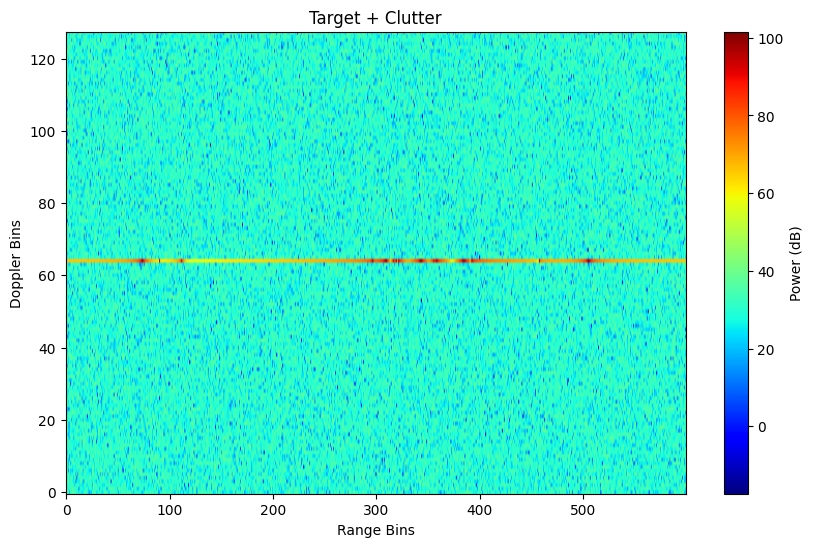

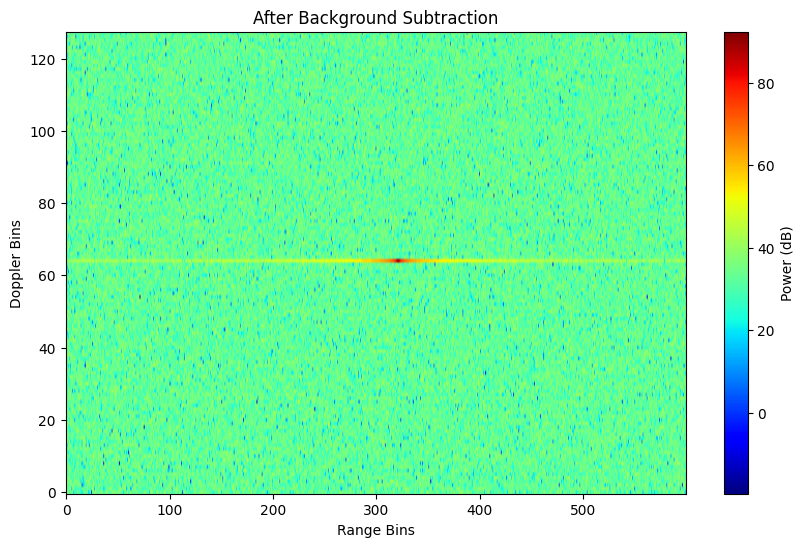

In [3]:
# 1. Generate Clutter Only (Background)
# We need to ensure the clutter is the SAME for both frames to simulate a static environment.
# Let's manually define the clutter targets.
clutter_targets = []
for _ in range(15):
    r = np.random.uniform(1, 20)
    if np.random.rand() > 0.7:
         r = np.random.uniform(11, 13)
    v = 0.0 # Static clutter
    rcs = np.random.uniform(0.5, 2.0)
    clutter_targets.append({'range': r, 'velocity': v, 'rcs': rcs})

# 2. Generate Target
target_metal = [{'range': 12.0, 'velocity': 0.0, 'rcs': 0.8}]

# Frame 1: Background
cube_bg = generate_radar_cube(N_chirps, N_samples, clutter_targets)

# Frame 2: Background + Target
cube_tgt = generate_radar_cube(N_chirps, N_samples, clutter_targets + target_metal)

# Process
rd_bg = process_radar_cube(cube_bg)
rd_tgt = process_radar_cube(cube_tgt)

# 3. Subtraction
# We can subtract in Time Domain (Radar Cube) or Frequency Domain (Heatmap)
# Time domain subtraction is usually better for coherent subtraction.
cube_sub = cube_tgt - cube_bg
rd_sub = process_radar_cube(cube_sub)

plot_heatmap(rd_bg, title="Background (Clutter Only)")
plot_heatmap(rd_tgt, title="Target + Clutter")
plot_heatmap(rd_sub, title="After Background Subtraction")

## 3. Analysis

By subtracting the known static background, the hidden object (even if weak) becomes visible.
In a real deployment, we would take an average of N frames of the empty room to form the background model.